In [1]:

import numpy as np
import pydicom
import os
import sys
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

print(tf.__version__)
print(keras.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')
import cv2


2.8.1
2.8.0
Num GPUs Available:  1


In [2]:
fold = 6
DIR = '/home/shared/nps/coat_np_0' + str(fold) + '/'
lisdir = os.listdir(DIR)
print(len(lisdir))

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


6805


/tmp/ipykernel_3555326/56761993.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [3]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
fold_df = pd.read_csv('folds.csv')

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')

all_ids = all_ids.drop_duplicates('StudyInstanceUID')
files = pd.merge(files, all_ids)

files = files.drop(columns=['SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image','ycoord', 'contains_lung'])

files = pd.merge(files, fold_df)

/tmp/ipykernel_3555326/499452058.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')
/tmp/ipykernel_3555326/499452058.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [4]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)
    all_ids_slab['pe_in_slab'] = all_ids_slab['pe_in_slab'] + all_ids_slab['pe_' + str(i)]

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)

/tmp/ipykernel_3555326/1481971415.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [5]:
all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID.isin(files.StudyInstanceUID.unique())]

In [6]:
DIR

'/home/shared/nps/coat_np_06/'

In [67]:
for fold in range(1,10):
    all_preds = []
    all_ids_slab['pred_0'+str(fold)] = -1
    DIR = '/home/shared/nps/coat_np_0'+str(fold)+'/'
    for i in range(len(all_ids_slab.StudyInstanceUID.unique())):
        study_id = all_ids_slab.StudyInstanceUID.unique()[i]
        scan = pd.DataFrame(np.load(DIR +study_id + '.npy', allow_pickle=True).tolist())
        all_preds = np.append(all_preds , scan['preds'].tolist())
    all_ids_slab['pred_0'+str(fold)] = all_preds
    

In [68]:
for fold in range(2,10):
    all_preds = []
    all_ids_slab['pred_0'+str(fold)] = -1
    DIR = '/home/shared/nps/coat_np_0'+str(fold)+'/'
    for i in range(len(all_ids_slab.StudyInstanceUID.unique())):
        study_id = all_ids_slab.StudyInstanceUID.unique()[i]
        scan = pd.DataFrame(np.load(DIR +study_id + '.npy', allow_pickle=True).tolist())
        all_preds = np.append(all_preds , scan['preds'].tolist())
    all_ids_slab['pred_0'+str(fold)] = all_preds


In [55]:
all_ids_lung = all_ids_slab[all_ids_slab.pe_present_on_image == True].reset_index(drop=True)

In [56]:
all_ids_lung.loc[0:8682, 'pred_00'] = all_preds


In [57]:
all_ids_lung

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,...,ycoord,contains_lung,endStudyUID,pe_in_slab,pe_1,SOP_1,pe_2,SOP_2,pred,pred_00
0,004f9a1605e7,d24902cc3c42,ad20e3f045dd,1,0,0,0,0,1,0,...,-136.00,True,004f9a1605e7,False,0.0,d17bd2577069,0.0,3eb09e9929a6,-1,0.000816
1,004f9a1605e7,d24902cc3c42,1779a65d9a40,1,0,0,0,0,1,0,...,-134.75,True,004f9a1605e7,True,1.0,ad20e3f045dd,0.0,d17bd2577069,-1,0.002312
2,004f9a1605e7,d24902cc3c42,4e40fad5249a,1,0,0,0,0,1,0,...,-133.50,True,004f9a1605e7,True,1.0,1779a65d9a40,1.0,ad20e3f045dd,-1,0.000763
3,004f9a1605e7,d24902cc3c42,1f253b7965dd,1,0,0,0,0,1,0,...,-132.25,True,004f9a1605e7,True,1.0,4e40fad5249a,1.0,1779a65d9a40,-1,0.002875
4,004f9a1605e7,d24902cc3c42,2eb9f68693c7,1,0,0,0,0,1,0,...,-131.00,True,004f9a1605e7,True,1.0,1f253b7965dd,1.0,4e40fad5249a,-1,0.002770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95739,fff9536823b1,e717e6613e0e,319f0b1dbdc2,1,0,0,0,0,0,1,...,2105.40,True,fff9536823b1,True,1.0,4a1b85708352,1.0,49097c655d05,-1,-1.000000
95740,fff9536823b1,e717e6613e0e,edad36de8852,1,0,0,0,0,0,1,...,2106.20,True,fff9536823b1,True,1.0,319f0b1dbdc2,1.0,4a1b85708352,-1,-1.000000
95741,fff9536823b1,e717e6613e0e,05b240069dad,1,0,0,0,0,0,1,...,2107.00,True,fff9536823b1,True,1.0,edad36de8852,1.0,319f0b1dbdc2,-1,-1.000000
95742,fff9536823b1,e717e6613e0e,b1a7f7011fe3,1,0,0,0,0,0,1,...,2107.80,True,fff9536823b1,True,1.0,05b240069dad,1.0,edad36de8852,-1,-1.000000


In [44]:
all_ids_lung[8680:8690]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,...,ycoord,contains_lung,endStudyUID,pe_in_slab,pe_1,SOP_1,pe_2,SOP_2,pred,pred_00
110706,17d262ecc0b1,836f9c970c22,ed038785c7f0,1,0,0,0,0,1,0,...,-265.90,True,17d262ecc0b1,False,0.0,b6f0492c3d75,0.0,041ebc1f1cbe,-1,-1
110707,17d262ecc0b1,836f9c970c22,35ae4ec89d5b,1,0,0,0,0,1,0,...,-264.65,True,17d262ecc0b1,True,1.0,ed038785c7f0,0.0,b6f0492c3d75,-1,-1
110708,17d262ecc0b1,836f9c970c22,93e74fdef8d8,1,0,0,0,0,1,0,...,-263.40,True,17d262ecc0b1,True,1.0,35ae4ec89d5b,1.0,ed038785c7f0,-1,-1
110709,17d262ecc0b1,836f9c970c22,0524cf56a05c,1,0,0,0,0,1,0,...,-262.15,True,17d262ecc0b1,True,1.0,93e74fdef8d8,1.0,35ae4ec89d5b,-1,-1
110710,17d262ecc0b1,836f9c970c22,143549d2ba8d,1,0,0,0,0,1,0,...,-260.90,True,17d262ecc0b1,True,1.0,0524cf56a05c,1.0,93e74fdef8d8,-1,-1
110711,17d262ecc0b1,836f9c970c22,37ff66d2b1e0,1,0,0,0,0,1,0,...,-259.65,True,17d262ecc0b1,True,1.0,143549d2ba8d,1.0,0524cf56a05c,-1,-1
110712,17d262ecc0b1,836f9c970c22,031b7a5747a6,1,0,0,0,0,1,0,...,-258.40,True,17d262ecc0b1,True,1.0,37ff66d2b1e0,1.0,143549d2ba8d,-1,-1
110713,17d262ecc0b1,836f9c970c22,e1bcfbb045bc,1,0,0,0,0,1,0,...,-257.15,True,17d262ecc0b1,True,1.0,031b7a5747a6,1.0,37ff66d2b1e0,-1,-1
110714,17d262ecc0b1,836f9c970c22,3d148ac67b91,1,0,0,0,0,1,0,...,-255.90,True,17d262ecc0b1,True,1.0,e1bcfbb045bc,1.0,031b7a5747a6,-1,-1
110715,17d262ecc0b1,836f9c970c22,3d7e4541f975,1,0,0,0,0,1,0,...,-254.65,True,17d262ecc0b1,True,1.0,3d148ac67b91,1.0,e1bcfbb045bc,-1,-1


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_version(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred.round())

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
    print(cm)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()
    # plt.show()

In [106]:
all_pred_flat =[]
for i in range(len(all_preds)):
    for j in range(len(all_preds[i])):
        all_pred_flat.append(all_preds[i][j])


In [107]:
all_ids_slab['pred'] = np.asarray(all_pred_flat).flatten()

In [115]:
test_neg = all_ids_test[all_ids_test.negative_exam_for_pe == True]
len(test_neg[test_neg.pred > 0.5]), len(test_neg)

(6617, 58486)

In [121]:
test_pos = all_ids_test[all_ids_test.negative_exam_for_pe == False]
test_pos = test_pos[test_pos.pe_present_on_image == False]
len(test_pos[test_pos.pred > 0.5]), len(test_pos)

(3443, 22472)

In [124]:
6617/58486*100, 8653/29493*100, 3443/22472*100

(11.313818691652704, 29.339165225646763, 15.32128871484514)

4
 0.8753865918066327 
 0.7738195026543727 
 0.9784738934464373 
 0.3458632532001249 
 0.8674171836976301
[[73592 10476]
 [ 1619  5539]]


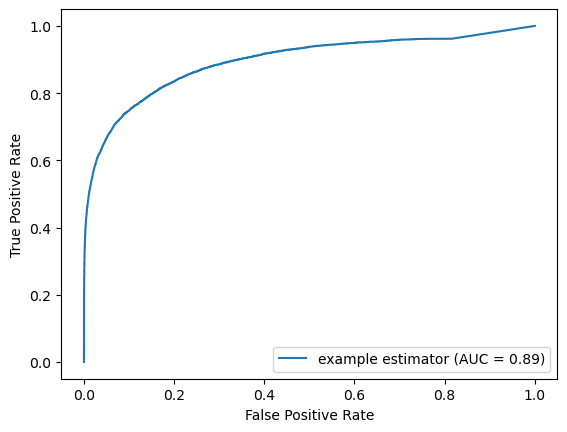

In [93]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

5
 0.8699035717428747 
 0.7930331084261729 
 0.9812939641479465 
 0.32813920270094793 
 0.8642014107130386
[[69193 10348]
 [ 1319  5054]]


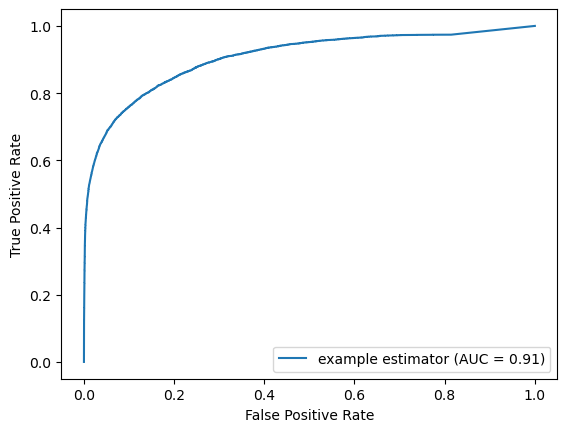

In [100]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

6
 0.8757889796069616 
 0.7427350427350428 
 0.9751612592663906 
 0.34145383104125737 
 0.8651723706793667
[[70903 10056]
 [ 1806  5214]]


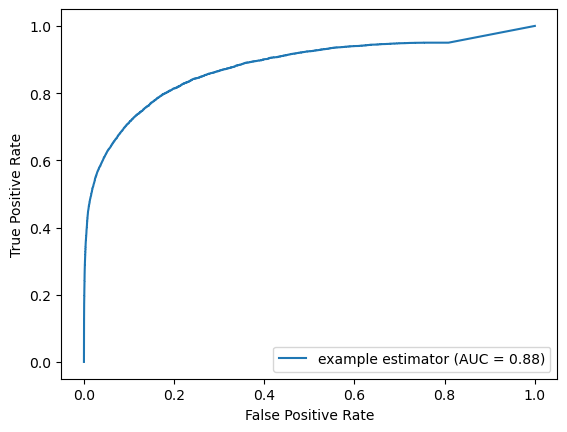

In [109]:
fold_df = pd.read_csv('folds.csv')
print(fold)

all_ids_slab = pd.merge(all_ids_slab, fold_df)
all_ids_test = all_ids_slab[all_ids_slab.fold == fold]

test_version(all_ids_test.pe_in_slab, all_ids_test.pred)

In [132]:
all_ids_slab['pe_in_slab8'] = all_ids_slab.pe_in_slab
for i in range(1, 8):
    all_ids_slab['pred_8' + str(i)] = all_ids_slab.pred.shift(i)
    all_ids_slab['Study_' + str(i)] = all_ids_slab.StudyInstanceUID.shift(i)
    all_ids_slab['pe_in_slab8'] = all_ids_slab['pe_in_slab8'] + all_ids_slab.pe_in_slab.shift(i)

In [133]:
all_ids_slab8 = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.Study_7]

In [136]:
all_ids_slab8 = all_ids_slab8.drop(columns=['SOP_7','Study_1','Study_2','Study_3','Study_4','Study_5','Study_6','Study_7'])

In [148]:
all_ids_slab8['pred_8'] = np.round(all_ids_slab['pred'])
for i in range(1,8):
    all_ids_slab8['pred_8'] = all_ids_slab8['pred_8']+ np.round(all_ids_slab8['pred_8'+ str(i)])

In [161]:
all_ids_slab8_neg = all_ids_slab8[all_ids_slab8.negative_exam_for_pe == True]
all_ids_slab8_pos = all_ids_slab8[all_ids_slab8.negative_exam_for_pe == False]

In [160]:
print(len(all_ids_slab8[(all_ids_slab8.pred_8 >4) & (all_ids_slab8.pe_in_slab8 >4)])/len(all_ids_slab8[all_ids_slab8.pred_8 >4]))
print(len(all_ids_slab8[(all_ids_slab8.pred_8 <4) & (all_ids_slab8.pe_in_slab8 <4)])/len(all_ids_slab8[all_ids_slab8.pred_8 <4]))

0.4446225130368353
0.980537512375341


In [165]:
len(all_ids_slab8_neg[all_ids_slab8_neg.pred_8 >4])/len(all_ids_slab8_neg.StudyInstanceUID.unique())

11.741638539429273

In [168]:
len(all_ids_slab8_pos[all_ids_slab8_pos.pred_8 >4])/len(all_ids_slab8_pos.StudyInstanceUID.unique())

48.30217519106408

In [172]:
all_studys = all_ids_slab.drop_duplicates('StudyInstanceUID')

In [175]:
all_studys = all_studys.drop(columns=['contains_lung', 'endStudyUID', 'pe_in_slab', 'pe_1', 'SOP_1',
       'pe_2', 'SOP_2', 'pred', 'fold', 'pe_in_slab8', 'pred_81', 'pred_82',
       'pred_83', 'SOP_3', 'pred_84', 'SOP_4', 'pred_85', 'SOP_5', 'pred_86',
       'SOP_6', 'pred_87', 'SOP_7', 'Study_1', 'Study_2', 'Study_3', 'Study_4',
       'Study_5', 'Study_6', 'Study_7'])

In [197]:
# all_studys = all_studys.reset_index(drop=True)
all_studys['len'] = -1
for i in range(len(all_studys)):
    study_id = all_studys.StudyInstanceUID.unique()[i]
    all_studys.loc[i, 'len'] = len(all_ids_slab8[(all_ids_slab8.StudyInstanceUID == study_id)])
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950


In [202]:
all_studys['avg'] = all_studys.sum_8/all_studys.len
all_studys_neg = all_studys[all_studys.negative_exam_for_pe == True]
all_studys_pos = all_studys[all_studys.negative_exam_for_pe == False]

In [207]:
all_studys_neg.avg.quantile(0.7), all_studys_pos.avg.quantile(0.23)

(0.08237578276682433, 0.1016949152542373)

In [2]:
import argparse
import os
import random as rn
import sys
from typing import Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
import random

# import config
# from pe_logger import PELogger
# from plots.plot_results import (save_accuracy_plot, save_loss_plot,
#                                 save_pr_curve, save_roc_curve)
from inception_resnet_v2_gray import InceptionResNetV2Gray
# from training.slice_data_generator import SliceDataGenerator

# Set seeding based on Keras documentation
np.random.seed(1)
rn.seed(2)
tf.random.set_seed(3)

# logger = PELogger().get_logger()

# CONFIG = config.config()
# MODEL_DIR = CONFIG["model"]["model_dir"]
# PLOT_DIR = CONFIG["model"]["plot_dir"]
IMAGE_W = 386
IMAGE_H = 386
ENCODING_DIM = 64
# FILENAME_COL = "png_filename"
# LABEL_COL = "label"
# FOLD_COL = "pat_fold"
EPOCHS = 9
BATCH_SIZE = 32
MODEL_DIR = '/home/shared/model_checkpoint_paige/singlescan-3channel//'

CROPPED = 0
MASKED = 1
ORIGINAL = 2

IMG_TYPE = 0
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 16


In [3]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

/tmp/ipykernel_1579989/1656503385.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [4]:
test_df = pd.read_csv('test_df_upd.csv').drop(columns='Unnamed: 0')


In [5]:
all_ids.ycoord = all_ids.ycoord.astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)
    all_ids_slab['pe_in_slab'] = all_ids_slab['pe_in_slab'] + all_ids_slab['pe_' + str(i)]

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)
print(len(all_ids_slab[all_ids_slab.pe_in_slab ==True]), len(all_ids_slab[all_ids_slab.pe_present_on_image == True]))

test_slab = all_ids_slab[all_ids_slab.StudyInstanceUID.isin(test_df.StudyInstanceUID)]


95746 95744


In [4]:
def get_model(num_channels: int) -> keras.models.Model:
    
    from keras_cv_attention_models import coatnet
    
    inputs = keras.Input(shape=(256,256,3))
    
    coat = coatnet.CoAtNet0(pretrained='imagenet', num_classes=512, classifier_activation='relu', input_shape=(256,256,3), drop_connect_rate = 0.03)

    x = coat(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

def get_model_orig(num_channels: int) -> keras.models.Model:
    
    from keras_cv_attention_models import coatnet
    
    inputs = keras.Input(shape=(256,256,3))
    
    coat = coatnet.CoAtNet0(pretrained='imagenet', num_classes=512, classifier_activation='relu', input_shape=(256,256,3))

    x = coat(inputs)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

def get_conv_model(num_channels: int) -> keras.models.Model:
    
    from keras_cv_attention_models import convnext
    
    inputs = keras.Input(shape=(256,256,3))
    conv = convnext.ConvNeXtSmall(pretrained='imagenet', num_classes=512, classifier_activation='relu', input_shape=(256,256,3))

    x = conv(inputs)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

def get_turku_model(num_channels: int) -> keras.models.Model:
    
    inputs = keras.Input(shape=(IMAGE_W,IMAGE_H,1))
    
    inception = InceptionResNetV2Gray(
                    input_shape=(IMAGE_H, IMAGE_W, 1),
                    include_top=False,
                    weights='pretrained/InceptionResNetV2_NIH15_Px256.h5',
                )
    x = inception(inputs)
    x = keras.layers.GlobalAveragePooling2D()(inception.output)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(ENCODING_DIM)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inception.input, outputs=x)
    return model



In [5]:
import turku_aug_funcs

class DataSlabGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path, img_type,
                 n_channels=1, to_fit=True, batch_size=32, dim=256, num_pos=None,
                 n_classes=2, shuffle=True, verbose=False, set_type='valid', fold=0,
                 convex_hull = False, full_set = None, resample = False):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path_dicom = image_path
        self.verbose = verbose
        self.img_type = img_type
        warnings.filterwarnings(action='ignore')
        self.full_set = full_set
        self.resample = resample
        self.fold = str(fold)
        self.set_type = set_type
        self.on_epoch_end()
        
    def get_df(self):
        return self.labels

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,self.dim,self.dim,3])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
            
        if self.verbose == True:
            fig, ax = plt.subplots(self.batch_size, 1, figsize=[12, 12*(self.batch_size/2)])
            for i in range(self.batch_size):
                ax[i].imshow(X[i])
                ax[i].axis('off')
        
        X = X/125.5 -1
            
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.resample == True:
            print('resampling')
            if self.set_type == 'valid':
                sample_set = self.full_set[self.full_set[self.fold+'fold'] == True]
                sample_set = sample_set.reset_index(drop=True)
                set_pos = sample_set[sample_set.pe_present_on_image ==True]
                set_neg = sample_set[sample_set.pe_present_on_image == False].sample(n=len(set_pos))
                self.labels = pd.concat([set_pos,set_neg]).sample(frac=1).reset_index(drop=True)

            if self.set_type == 'train':
                sample_set = self.full_set[self.full_set[self.fold+'fold'] == False]
                sample_set = sample_set.reset_index(drop=True)
                set_pos = sample_set[sample_set.pe_present_on_image ==True]
                set_neg = sample_set[sample_set.pe_present_on_image == False].sample(n=len(set_pos)*3)
                self.labels = pd.concat([set_pos,set_pos,set_pos,set_neg]).sample(frac=1).reset_index(drop=True)
            
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

    def _load_dicom(self, index):
        slice = self.labels.iloc[index] 

        frames = np.zeros((self.dim,self.dim,3))
        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOPInstanceUID +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,0] = frame

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOP_1 +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,1] = frame    

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOP_2 +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,2] = frame       
                
        if self.set_type == 'train':
            trans = random.sample(range(0,4),random.randint(0,4))

            if 0 in trans:
                frames = turku_aug_funcs.blur(frames)

            if 1 in trans:
                zoom = random.randint(0,2)
                if zoom == 0:
                    frames = turku_aug_funcs.zoom_1_05(frames)
                if zoom == 1:
                    frames = turku_aug_funcs.zoom_1_075(frames)
                if zoom == 2:
                    frames = turku_aug_funcs.zoom_1_15(frames)
            if 2 in trans:
                rot = random.randint(0,3)
                if rot == 0:
                    frames = turku_aug_funcs.rotate_3(frames)
                if rot == 1:
                    frames = turku_aug_funcs.rotate_m3(frames)
                if rot == 2:
                    frames = turku_aug_funcs.rotate_5(frames)
                if rot == 3:
                    frames = turku_aug_funcs.rotate_m5(frames)

            if 3 in trans:
                tx = random.randint(0,6)
                if tx == 0:
                    frames = turku_aug_funcs.tr_x10(frames)
                if tx == 1:
                    frames = turku_aug_funcs.tr_x15(frames)
                if tx == 2:
                    frames = turku_aug_funcs.tr_x20(frames)
                if tx == 3:
                    frames = turku_aug_funcs.tr_xm10(frames)
                if tx == 4:
                    frames = turku_aug_funcs.tr_xm15(frames)
                if tx == 5:
                    frames = turku_aug_funcs.tr_xm20(frames)
                tx = random.randint(0,6)
                if tx == 0:
                    frames = turku_aug_funcs.tr_y10(frames)
                if tx == 1:
                    frames = turku_aug_funcs.tr_y15(frames)
                if tx == 2:
                    frames = turku_aug_funcs.tr_y20(frames)
                if tx == 3:
                    frames = turku_aug_funcs.tr_ym10(frames)
                if tx == 4:
                    frames = turku_aug_funcs.tr_ym15(frames)
                if tx == 5:
                    frames = turku_aug_funcs.tr_ym20(frames)
        frames = np.reshape(frames, (256,256,3))
        
        if self.verbose == True:
            print(np.shape(frames))
            plt.imshow(frames[:,:,0])
            plt.show()

        frames = frames[None, ...]
        y = np.array([int(slice.pe_in_slab)])
        y = y[None, ...]
        
        return frames, y

/home/jupyter-paige/turku_aug_funcs.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/jupyter-paige/turku_aug_funcs.py:4: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [10]:
import turku_aug_funcs

class DataTurkuGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path, img_type,
                 n_channels=1, to_fit=True, batch_size=32, dim=256, num_pos=None,
                 n_classes=2, shuffle=True, verbose=False, set_type='valid', fold=0,
                 convex_hull = False, full_set = None, resample = False):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path_dicom = image_path
        self.verbose = verbose
        self.img_type = img_type
        warnings.filterwarnings(action='ignore')
        self.full_set = full_set
        self.resample = resample
        self.fold = str(fold)
        self.set_type = set_type
        self.on_epoch_end()
        
    def get_df(self):
        return self.labels

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,self.dim,self.dim,1])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
            
        if self.verbose == True:
            fig, ax = plt.subplots(self.batch_size, 1, figsize=[12, 12*(self.batch_size/2)])
            for i in range(self.batch_size):
                ax[i].imshow(X[i])
                ax[i].axis('off')
        
        X = X/127.5 -1
            
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.resample == True:
            print('resampling')
            if self.set_type == 'valid':
                sample_set = self.full_set[self.full_set[self.fold+'fold'] == True]
                sample_set = sample_set.reset_index(drop=True)
                set_pos = sample_set[sample_set.pe_present_on_image ==True]
                set_neg = sample_set[sample_set.pe_present_on_image == False].sample(n=len(set_pos))
                self.labels = pd.concat([set_pos,set_neg]).sample(frac=1).reset_index(drop=True)

            if self.set_type == 'train':
                sample_set = self.full_set[self.full_set[self.fold+'fold'] == False]
                sample_set = sample_set.reset_index(drop=True)
                set_pos = sample_set[sample_set.pe_present_on_image ==True]
                set_neg = sample_set[sample_set.pe_present_on_image == False].sample(n=len(set_pos)*2)
                self.labels = pd.concat([set_pos,set_pos,set_neg]).sample(frac=1).reset_index(drop=True)
            
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

    def _load_dicom(self, index):
        slice = self.labels.iloc[index] 

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOP_1 +'.png')
        frame = frame[:,:,self.img_type]

        frame = cv2.resize(frame, (386,386))
        frame = np.reshape(frame, (386,386,1))
        
        if self.verbose == True:
            print(np.shape(frame))
            plt.imshow(frame)
            plt.show()

        frame = frame[None, ...]
        y = np.array([int(slice.pe_1)])
        y = y[None, ...]
        
        return frame, y

CROPPED = 0
MASKED = 1
ORIGINAL = 2

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'


In [9]:
test_slab = test_slab.sample(frac=1).reset_index(drop=True)
test_mini = test_slab.iloc[:5000]

In [11]:
test_turku_generator = DataTurkuGenerator(np.arange(0, len(test_mini)),
                                   test_mini, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   resample=False, 
                                   n_channels=1, 
                                   batch_size=1,
                                   dim=386,
                                   shuffle=False)

x_turku = np.zeros([5000,386,386,1])
y_turku = np.zeros([5000,1])
for i in range(0,5000):
    x_turku[i],y_turku[i]= test_turku_generator.__getitem__(i)

In [12]:
test_generator = DataSlabGenerator(np.arange(0, len(test_mini)),
                                   test_mini, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   resample=False, 
                                   n_channels=3, 
                                   batch_size=1,
                                   shuffle=False)

x_test = np.zeros([5000,256,256,3])
y_test = np.zeros([5000,1])
for i in range(0,5000):
    x_test[i],y_test[i]= test_generator.__getitem__(i)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_version(model, weights, x_test, y_test):
    model.load_weights(weights)
    y_pred_tot = model.predict(x_test)

    cm = confusion_matrix(y_test, y_pred_tot.round())

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
    print(cm)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()
    # plt.show()

In [14]:
import warnings
warnings.filterwarnings('ignore')

2022-10-17 12:59:50.068269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 12:59:51.650567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11470 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:06:00.0, compute capability: 5.2


>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


2022-10-17 13:00:03.062291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-10-17 13:00:07.498277: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.
2022-10-17 13:00:14.734734: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-17 13:00:16.511147: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 0.8913938868415348 
 0.7286821705426356 
 0.9751007825468342 
 0.36015325670498083 
 0.8788
[[4112  501]
 [ 105  282]]


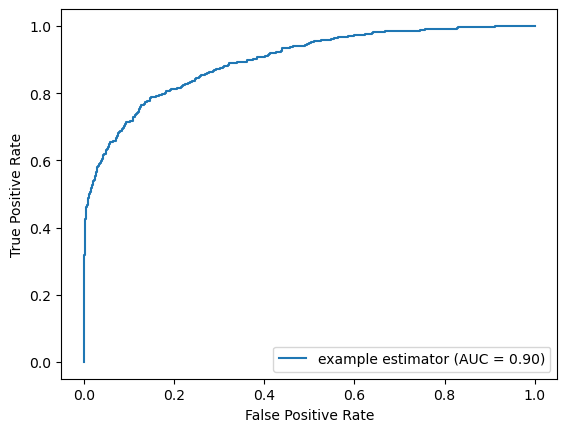

In [15]:
model = get_model(3)
test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold-2_fold_03.h5',
            x_test,
            y_test)

 0.9128549750704531 
 0.7338501291989664 
 0.9761242466388502 
 0.4139941690962099 
 0.899
[[4211  402]
 [ 103  284]]


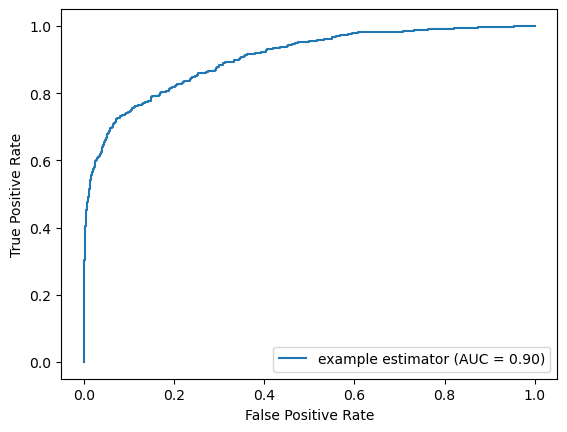

In [21]:
test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-best.h5',
            x_test,
            y_test)

>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


2022-10-17 13:02:16.501013: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3932160000 exceeds 10% of free system memory.


 0.9065683936700628 
 0.6925064599483204 
 0.9723320158102767 
 0.3834048640915594 
 0.89
[[4182  431]
 [ 119  268]]


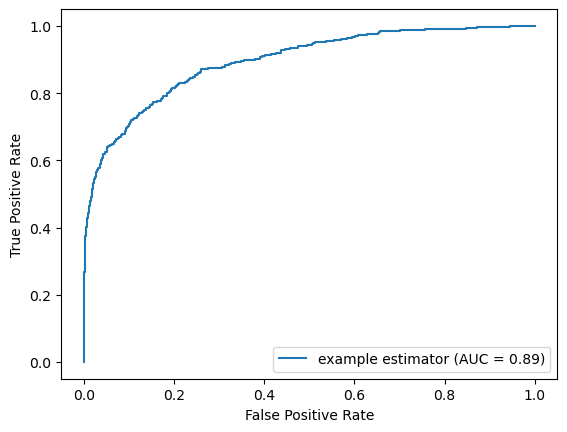

In [17]:
model = get_model_orig(1)
test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_00.h5',
            x_test,
            y_test)

>>>> Load pretrained from: /home/jupyter-paige/.keras/models/convnext_small_imagenet.h5
 0.8595274225016258 
 0.7467700258397932 
 0.9758798917056363 
 0.3084311632870864 
 0.8508
[[3965  648]
 [  98  289]]


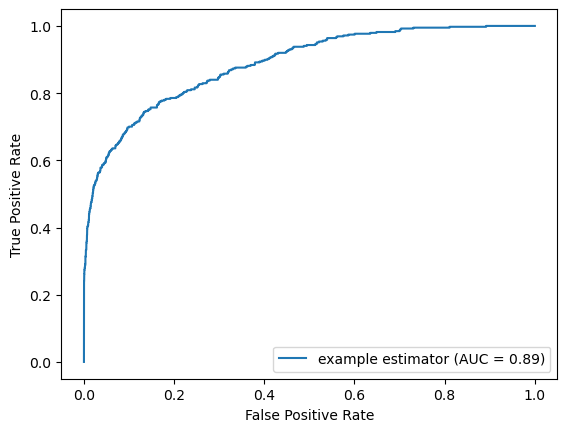

In [18]:
model = get_conv_model(0)
test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/conv-net-kfold_fold_00.h5',
            x_test,
            y_test)

 0.9100368523737264 
 0.7183462532299741 
 0.9746923612723474 
 0.40115440115440115 
 0.8952
[[4198  415]
 [ 109  278]]


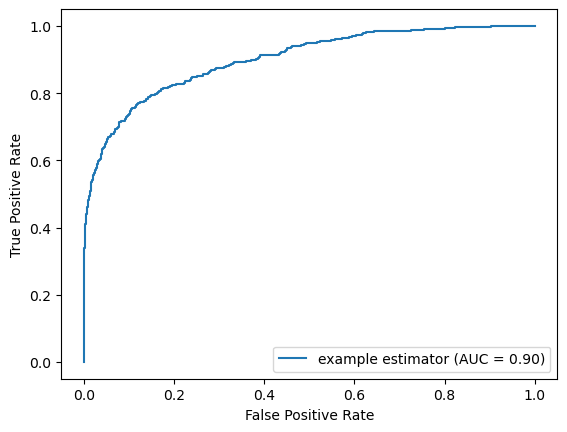

In [19]:
model = get_turku_model(1)
test_version(model, 
             '/home/shared/model_checkpoint_paige/turku/turku-incepres_fold_03.h5',
            x_turku,
            y_turku)

In [6]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

/tmp/ipykernel_1579989/1656503385.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [7]:
all_ids.ycoord = all_ids.ycoord.astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)

In [13]:
all_ids_small = all_ids_slab.drop(columns=['negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',
       'contains_lung','endStudyUID'])

In [10]:
model = get_model(3)
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-best.h5')
model_partial = keras.models.Model(inputs=model.input, outputs=[model.layers[-3].output])
model_partial.summary()

>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 coatnet0 (Functional)       (None, 512)               22930490  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                 

In [15]:
import datetime
import gc

In [20]:
all_ids_small

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,ycoord,pe_in_slab,pe_1,SOP_1,pe_2,SOP_2
0,0003b3d648eb,d2b2960c2bbf,a5561e6954f4,0,-296.75,False,0.0,e0866b2eb9a0,0.0,6068da522cc4
1,0003b3d648eb,d2b2960c2bbf,382770a065f4,0,-295.50,False,0.0,a5561e6954f4,0.0,e0866b2eb9a0
2,0003b3d648eb,d2b2960c2bbf,571418732f35,0,-294.25,False,0.0,382770a065f4,0.0,a5561e6954f4
3,0003b3d648eb,d2b2960c2bbf,4916256ab8f6,0,-293.00,False,0.0,571418732f35,0.0,382770a065f4
4,0003b3d648eb,d2b2960c2bbf,506413a4652c,0,-291.75,False,0.0,4916256ab8f6,0.0,571418732f35
...,...,...,...,...,...,...,...,...,...,...
1184562,fffda3f22362,39ca5eaafffe,63bcdac30827,0,-48.75,False,0.0,891980f20e99,0.0,cacd0e89fd60
1184563,fffda3f22362,39ca5eaafffe,3518d425e229,0,-47.50,False,0.0,63bcdac30827,0.0,891980f20e99
1184564,fffda3f22362,39ca5eaafffe,776810a1d086,0,-46.25,False,0.0,3518d425e229,0.0,63bcdac30827
1184565,fffda3f22362,39ca5eaafffe,d619df48a08d,0,-45.00,False,0.0,776810a1d086,0.0,3518d425e229


In [ ]:
unique_ids = all_ids_small.StudyInstanceUID.unique()

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids_small[all_ids_small.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam = exam.reset_index(drop=True)
    exam_generator = DataSlabGenerator(np.arange(0, len(exam)),
                                   exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   shuffle=False,
                                   n_channels=3, 
                                   batch_size=1,)
    
    x_test = np.zeros([len(exam),256,256,3])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
   
    feats = np.zeros([len(exam),64])
    preds = np.zeros([len(exam),1])
    for j in range(int(len(exam)/64)):
        preds[j*64:(j+1)*64] = model(x_test[j*64:(j+1)*64])
        feats[j*64:(j+1)*64] = np.array(model_partial(x_test[j*64:(j+1)*64]))
    if len(exam)%64 != 0:
        preds[(j+1)*64:] = model(x_test[(j+1)*64:])
        feats[(j+1)*64:] = np.array(model_partial(x_test[(j+1)*64:]))
        
    exam['pred'] = preds
    exam['features'] = feats.tolist()
    
    np.save('/home/shared/nps/coatnp/' + exam_id, exam.to_dict(orient='records'))
    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

0 time is:  2022-10-17 13:26:40.212854
10 time is:  2022-10-17 13:27:53.246020
20 time is:  2022-10-17 13:29:02.165207
30 time is:  2022-10-17 13:30:09.271560
40 time is:  2022-10-17 13:31:13.780818
50 time is:  2022-10-17 13:32:16.804486
60 time is:  2022-10-17 13:33:20.640849
70 time is:  2022-10-17 13:34:32.851874
80 time is:  2022-10-17 13:35:41.130247
90 time is:  2022-10-17 13:36:50.644041
100 time is:  2022-10-17 13:37:47.470938
110 time is:  2022-10-17 13:38:46.281999
120 time is:  2022-10-17 13:39:51.037326
130 time is:  2022-10-17 13:40:59.175427
140 time is:  2022-10-17 13:42:00.852563
150 time is:  2022-10-17 13:43:03.388576
160 time is:  2022-10-17 13:44:04.210901
170 time is:  2022-10-17 13:45:06.580187
180 time is:  2022-10-17 13:46:17.091520
190 time is:  2022-10-17 13:47:16.617170
200 time is:  2022-10-17 13:48:17.455119
210 time is:  2022-10-17 13:49:19.044079
220 time is:  2022-10-17 13:50:20.979660
230 time is:  2022-10-17 13:51:23.129116
240 time is:  2022-10-17 13

1980 time is:  2022-10-17 16:56:04.842015
1990 time is:  2022-10-17 16:57:12.375606
2000 time is:  2022-10-17 16:58:12.331229
2010 time is:  2022-10-17 16:59:23.819990
2020 time is:  2022-10-17 17:00:25.147426
2030 time is:  2022-10-17 17:01:25.691350
2040 time is:  2022-10-17 17:02:22.246670
2050 time is:  2022-10-17 17:03:25.194057
2060 time is:  2022-10-17 17:04:37.504801
2070 time is:  2022-10-17 17:05:34.621124
2080 time is:  2022-10-17 17:06:39.218370
2090 time is:  2022-10-17 17:07:46.660168
2100 time is:  2022-10-17 17:08:45.265722
2110 time is:  2022-10-17 17:09:51.735119
2120 time is:  2022-10-17 17:10:59.395108
2130 time is:  2022-10-17 17:12:17.647930
2140 time is:  2022-10-17 17:13:27.731912
2150 time is:  2022-10-17 17:14:30.668397
2160 time is:  2022-10-17 17:15:29.852761
2170 time is:  2022-10-17 17:16:29.729369
2180 time is:  2022-10-17 17:17:28.714624
2190 time is:  2022-10-17 17:18:29.910583
2200 time is:  2022-10-17 17:19:26.816117
2210 time is:  2022-10-17 17:20:32

3940 time is:  2022-10-17 19:59:10.897999
3950 time is:  2022-10-17 20:00:01.376421
3960 time is:  2022-10-17 20:00:51.438869
3970 time is:  2022-10-17 20:01:43.961279
3980 time is:  2022-10-17 20:02:37.893377
3990 time is:  2022-10-17 20:03:30.167545
4000 time is:  2022-10-17 20:04:21.240270
4010 time is:  2022-10-17 20:05:19.872939
4020 time is:  2022-10-17 20:06:09.611783
4030 time is:  2022-10-17 20:06:54.218985
4040 time is:  2022-10-17 20:07:45.120563
4050 time is:  2022-10-17 20:08:37.546756
4060 time is:  2022-10-17 20:09:30.806976
4070 time is:  2022-10-17 20:10:14.774440
4080 time is:  2022-10-17 20:10:59.183847
4090 time is:  2022-10-17 20:11:46.883520
4100 time is:  2022-10-17 20:12:36.408465
4110 time is:  2022-10-17 20:13:25.991869
4120 time is:  2022-10-17 20:14:12.275231
4130 time is:  2022-10-17 20:14:59.961549
4140 time is:  2022-10-17 20:15:46.761257
4150 time is:  2022-10-17 20:16:38.381548
4160 time is:  2022-10-17 20:17:43.489440
4170 time is:  2022-10-17 20:18:32

In [159]:
all_tot = pd.read_csv('/home/data/pe/train.csv')
all_ids_slab = all_ids_slab.drop(columns='fold')

In [160]:
tot = pd.merge(all_tot, all_ids_slab, how='left', on=['StudyInstanceUID','SOPInstanceUID','qa_contrast','qa_motion','flow_artifact','rv_lv_ratio_gte_1','negative_exam_for_pe','pe_present_on_image','rv_lv_ratio_lt_1','leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',]).fillna(0)

In [161]:
tot['pe_in_slab'] = tot.pe_in_slab.astype(int)

In [162]:
tot = pd.merge(tot, fold_df)

Sensitivity:85.31 
Specificity:92.3 
PPV:37.36 
NPV:99.15 
Accuracy:91.94 
Loss:0.2057
[[145017  12099]
 [  1243   7217]]
Sensitivity:82.14 
Specificity:92.18 
PPV:39.81 
NPV:98.79 
Accuracy:91.58 
Loss:0.2178
[[144442  12256]
 [  1762   8105]]


/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)


Sensitivity:85.72 
Specificity:88.21 
PPV:32.03 
NPV:98.96 
Accuracy:88.06 
Loss:0.2835
[[137178  18341]
 [  1440   8642]]
Sensitivity:80.34 
Specificity:91.23 
PPV:34.95 
NPV:98.75 
Accuracy:90.63 
Loss:0.2306
[[145590  13992]
 [  1840   7519]]


/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)


Sensitivity:84.26 
Specificity:91.18 
PPV:35.66 
NPV:99.01 
Accuracy:90.8 
Loss:0.2105
[[145815  14100]
 [  1460   7815]]
Sensitivity:83.71 
Specificity:92.51 
PPV:38.88 
NPV:99.01 
Accuracy:92.03 
Loss:0.1943
[[145395  11775]
 [  1457   7489]]


/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)


Sensitivity:79.16 
Specificity:93.26 
PPV:40.36 
NPV:98.73 
Accuracy:92.5 
Loss:0.2262
[[146956  10613]
 [  1891   7182]]
Sensitivity:78.76 
Specificity:92.14 
PPV:42.03 
NPV:98.36 
Accuracy:91.24 
Loss:0.2415
[[145402  12399]
 [  2424   8989]]


/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)


Sensitivity:87.23 
Specificity:88.04 
PPV:31.05 
NPV:99.11 
Accuracy:88.0 
Loss:0.275
[[140561  19088]
 [  1258   8595]]
Sensitivity:74.61 
Specificity:93.74 
PPV:41.97 
NPV:98.38 
Accuracy:92.64 
Loss:0.2008
[[145395   9715]
 [  2391   7027]]


/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
/tmp/ipykernel_3555326/2447563028.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)


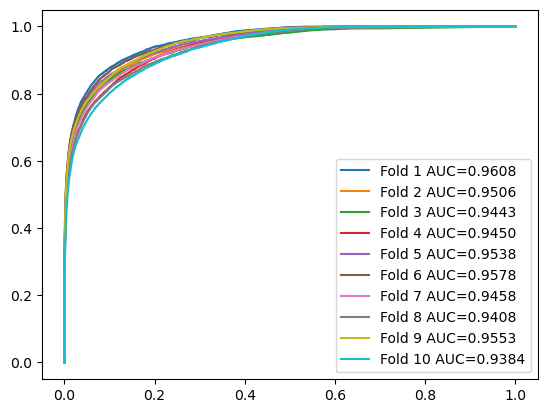

In [302]:
plt.figure(0).clf()
rest = pd.DataFrame(columns=['fold','auc','sensitivity', 'specificity', 'accuracy','npv','ppv'])


for fold in range(0,10):
    allslab = tot[(tot.fold == fold)]
    (fpr,tpr), data, cm = test_version(allslab.pe_in_slab, allslab['pred_0'+str(fold)])
    
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr, label='Fold '+str(fold +1)+' AUC={:.4f}'.format(auc))

    #     plt.show(plot)    
    rest = rest.append({'fold':fold,'auc':data[0],'sensitivity':data[1], 'specificity':data[2], 'accuracy':data[3], 'npv':data[4],'ppv':data[5]}, ignore_index=True)
plt.legend()
plt.show()

In [182]:
res.mean() + 0.95 * res.std()/np.sqrt(10)

fold           5.409556
auc            0.930075
sensitivity    0.832918
specificity    0.885116
accuracy       0.879290
npv            0.983620
ppv            0.385828
dtype: float64

In [190]:
ids = tot[(tot.contains_lung == False) & (tot.pe_present_on_image == True)].StudyInstanceUID.unique()

In [192]:
tot[tot.StudyInstanceUID.isin(ids) & (tot.pe_present_on_image == True)]

,StudyInstanceUID,SeriesInstanceUID_x,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,...,pred_01,pred_02,pred_03,pred_04,pred_05,pred_06,pred_07,pred_08,pred_09,fold
19959,0a970be732a9,0d7059ed9ebf,c07d8cc6f96d,1,0,0,0,0,0,1,...,0.028480,0.574011,0.031243,0.002710,0.378553,0.118931,0.208735,0.187029,0.348989,4
19960,0a970be732a9,0d7059ed9ebf,d0b266921683,1,0,0,0,0,0,1,...,0.006044,0.416346,0.007329,0.002075,0.006297,0.254444,0.180383,0.003697,0.208711,4
19962,0a970be732a9,0d7059ed9ebf,d7e77bdb0fd5,1,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
19963,0a970be732a9,0d7059ed9ebf,bf6ff4598b45,1,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
19964,0a970be732a9,0d7059ed9ebf,ae35c23f90ba,1,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504369,02ac16a103aa,9478cbc26244,b84fd0be9aa5,1,0,0,0,0,1,0,...,0.144421,0.811539,0.171389,0.001030,0.962445,0.260160,0.383793,0.493800,0.212621,4
1504372,02ac16a103aa,9478cbc26244,003d0600174a,1,0,0,0,0,1,0,...,0.935153,0.974648,0.929581,0.880140,0.995803,0.988971,0.879229,0.988542,0.777976,4
1504376,02ac16a103aa,9478cbc26244,6f66a2249c76,1,0,0,0,0,1,0,...,0.307176,0.739925,0.761979,0.624690,0.736329,0.522398,0.311496,0.551261,0.169202,4
1504380,02ac16a103aa,9478cbc26244,446e91adaeec,1,0,0,0,0,1,0,...,0.604510,0.947398,0.791668,0.830227,0.519644,0.514621,0.474122,0.937070,0.340616,4


In [197]:
sub = tot[(tot.pe_present_on_image == True) & (tot.contains_lung == False)].reset_index(drop=True)

In [297]:
count

6

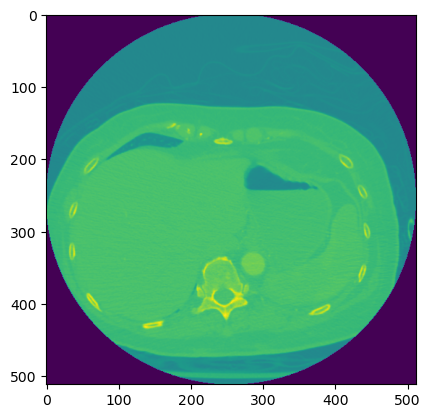

In [298]:
i = i-1
print_image(sub.iloc[i].StudyInstanceUID, sub.iloc[i].SeriesInstanceUID_x, sub.iloc[i].SOPInstanceUID)

In [203]:
image_path = "/home/data/rsna-str-pulmonary-embolism-detection/train"
def print_image(study, series, sop):
    data = pydicom.dcmread(os.path.join(image_path, study, series , sop + '.dcm'))
    intercept = int(float(data.get_item([0x0028, 0x1052]).value)) 
    slope = int(float(data.get_item([0x0028, 0x1053]).value))                
    frame = np.asarray(data.pixel_array  * slope + intercept)
    frame = frame.reshape((512,512)) 
    plt.imshow(frame)
#     plt.show()

In [183]:
res.mean() - 0.95 * res.std()/np.sqrt(10)

fold           3.590444
auc            0.923498
sensitivity    0.809567
specificity    0.868106
accuracy       0.864973
npv            0.981139
ppv            0.362363
dtype: float64

In [308]:
rest.mean()

fold           4.500000
auc            0.949262
sensitivity    0.821243
specificity    0.914795
accuracy       0.909423
npv            0.988259
ppv            0.374095
dtype: float64

In [311]:
len(tot[tot.pe_in_slab ==True])/len(tot[tot.pe_in_slab == True].StudyInstanceUID.unique())

44.00091911764706

In [324]:
avg_pos_in_pos = 0
avg_true_pos = 0
avg_false_pos_in_pos = 0
avg_pos_in_neg = 0

for fold in range(0,10):
    allslab = all_ids_slab[all_ids_slab.fold == fold]
    allpos = allslab[allslab.negative_exam_for_pe == False]
    allneg = allslab[allslab.negative_exam_for_pe == True]
    num_pos_in_pos = len(allpos[allpos['pred_0'+str(fold)] > 0.5])/len(allpos.StudyInstanceUID.unique())
    num_true_pos = len(allpos[(allpos['pred_0'+str(fold)]>0.5) & (allpos.pe_in_slab == True)])/len(allpos.StudyInstanceUID.unique())
    num_false_pos_in_pos = len(allpos[(allpos['pred_0'+str(fold)]>0.5) & (allpos.pe_in_slab == False)])/len(allpos.StudyInstanceUID.unique())
    num_pos_in_neg = len(allneg[allneg['pred_0'+str(fold)]>0.5])/len(allneg.StudyInstanceUID.unique())
    
    avg_pos_in_pos = avg_pos_in_pos + num_pos_in_pos
    avg_true_pos = avg_true_pos + num_true_pos
    avg_false_pos_in_pos = avg_false_pos_in_pos + num_false_pos_in_pos
    avg_pos_in_neg = avg_pos_in_neg + num_pos_in_neg
    
    print(str(fold) + ' Pos In Pos {:.3f} True Pos {:.3f} False Pos in Pos {:.3f} Pos in Neg {:.3f}'.format(num_pos_in_pos, num_true_pos, num_false_pos_in_pos, num_pos_in_neg))
    print()
    
avg_pos_in_pos = avg_pos_in_pos/10
avg_true_pos = avg_true_pos / 10
avg_false_pos_in_pos = avg_false_pos_in_pos/10
avg_pos_in_neg = avg_pos_in_neg/10

print('Pos In Pos {:.3f} True Pos {:.3f} False Pos in Pos {:.3f} Pos in Neg {:.3f}'.format(avg_pos_in_pos,avg_true_pos,avg_false_pos_in_pos,avg_pos_in_neg))


0 Pos In Pos 54.380 True Pos 33.883 False Pos in Pos 20.498 Pos in Neg 16.524

1 Pos In Pos 54.132 True Pos 34.637 False Pos in Pos 19.496 Pos in Neg 17.213

2 Pos In Pos 66.316 True Pos 36.464 False Pos in Pos 29.852 Pos in Neg 25.374

3 Pos In Pos 54.935 True Pos 32.691 False Pos in Pos 22.243 Pos in Neg 19.681

4 Pos In Pos 56.696 True Pos 36.014 False Pos in Pos 20.682 Pos in Neg 20.716

5 Pos In Pos 54.518 True Pos 32.846 False Pos in Pos 21.671 Pos in Neg 15.119

6 Pos In Pos 50.691 True Pos 32.206 False Pos in Pos 18.484 Pos in Neg 14.204

7 Pos In Pos 53.061 True Pos 34.309 False Pos in Pos 18.752 Pos in Neg 17.909

8 Pos In Pos 63.420 True Pos 35.370 False Pos in Pos 28.049 Pos in Neg 28.082

9 Pos In Pos 45.877 True Pos 29.775 False Pos in Pos 16.102 Pos in Neg 13.322

Pos In Pos 55.403 True Pos 33.820 False Pos in Pos 21.583 Pos in Neg 18.814


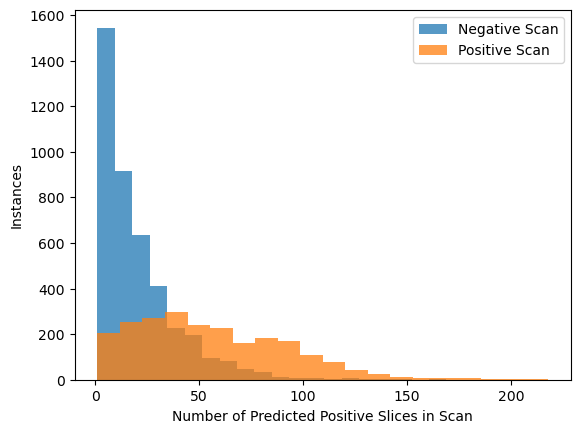

In [351]:
# false_neg = np.array([])
# all_pos = np.array([])

# for fold in range(0,10):
#     allslab = all_ids_slab[all_ids_slab.fold == fold]
#     allpos = allslab[allslab.negative_exam_for_pe == False]
#     allneg = allslab[allslab.negative_exam_for_pe == True]
    
#     false_neg = np.append(false_neg, allneg[allneg['pred_0'+str(fold)] > 0.5].StudyInstanceUID.value_counts())
#     all_pos = np.append(all_pos, allpos[allpos['pred_0'+str(fold)]>0.5].StudyInstanceUID.value_counts())
               
#     print(fold)

plt.hist(false_neg, 20, alpha = 0.75, label='Negative Scan')
plt.hist(all_pos, 20, alpha=0.75, label='Positive Scan')
plt.xlabel('Number of Predicted Positive Slices in Scan')
plt.ylabel('Instances')
plt.legend()
plt.show()

avg_pos_in_pos = avg_pos_in_pos/10
avg_true_pos = avg_true_pos / 10
avg_false_pos_in_pos = avg_false_pos_in_pos/10
avg_pos_in_neg = avg_pos_in_neg/10


In [331]:
false_neg.values

array([106,  77,  73,  71,  69,  62,  61,  60,  58,  53,  51,  51,  49,
        48,  47,  46,  45,  44,  42,  41,  41,  41,  41,  40,  39,  38,
        38,  38,  35,  35,  34,  33,  33,  33,  33,  33,  33,  32,  32,
        32,  31,  31,  30,  30,  30,  30,  29,  29,  29,  29,  28,  28,
        28,  28,  28,  28,  28,  27,  27,  27,  26,  26,  26,  26,  26,
        25,  25,  25,  25,  25,  24,  24,  24,  24,  23,  23,  23,  23,
        22,  22,  22,  22,  22,  21,  21,  21,  21,  21,  21,  21,  21,
        21,  20,  20,  20,  20,  20,  20,  19,  19,  19,  19,  19,  19,
        19,  19,  19,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,
        17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
        16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
        16,  16,  16,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
        15,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  14,  13,  13,  13,  13,  13,  13,  13,  1

In [178]:
tot.pe_in_slab.mean()

0.057268635514018694

fold           4.500000
auc            0.949262
sensitivity    0.821243
specificity    0.914795
accuracy       0.909423
npv            0.988259
ppv            0.374095
dtype: float64

In [172]:
all_ids_slab[all_ids_slab.true_filling_defect_not_pe == True].negative_exam_for_pe.mean()

0.5989894823674985

In [141]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

tf.config.experimental.enable_op_determinism()

def test_version(y_test, y_pred, offset=0, turku=False):

    cm = confusion_matrix(y_test, y_pred.round())
        
    sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
    sepecifity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    npv = cm[0][0]/(cm[0][0]+cm[1][0])
    ppv = cm[1][1]/(cm[1][1]+cm[0][1])
    loss = metrics.log_loss(y_test, y_pred)

    print('Sensitivity:{:.4}'.format(sensitivity*100),
          '\nSpecificity:{:.4}'.format(sepecifity*100),
          '\nPPV:{:.4}'.format(ppv*100),
          '\nNPV:{:.4}'.format(npv*100),
          '\nAccuracy:{:.4}'.format(accuracy*100),
          '\nLoss:{:.4}'.format(loss))
    print(cm)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    return (fpr,tpr), [roc_auc, sensitivity, sepecifity, accuracy, npv, ppv], cm